In [35]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessData(object):
    def __init__(self, X, y, coverage):
        self.X = X
        self.y = y
        self.coverage = coverage
#         self.ip_dict = ip_dict
#         self.ip_reserve_list = ip_reserve_list
#         self.data_scaler = data_scaler


In [36]:
time_window = 240
time_steps = 20
dimension = 32
n_class = 2

In [37]:
import pickle
# fp = open('iPAccessData_time_window_'+str(time_window)+'.pkl','rb',True)
fp = open('iPAccessData_count.pkl','rb',True)
iPAccessData = pickle.load(fp)
# X = iPAccessData.X
# labels = iPAccessData.y

In [41]:
iPAccessData.y.shape

(13385,)

In [42]:
#截取一部分数据（因为正常数据太多了）
X0 = iPAccessData.X[iPAccessData.y==0]
C0 = iPAccessData.coverage[iPAccessData.y==0]
# random_select = np.random.choice(X0.shape[0], 6000) #随即选择200个数据
# X0 = X0[random_select]

X1 = iPAccessData.X[iPAccessData.y==1]
C1 = iPAccessData.coverage[iPAccessData.y==1]

# X2 = iPAccessData.X[iPAccessData.y==2,:,:]
# C2 = iPAccessData.coverage[iPAccessData.y==2,:,:]
# random_select = np.random.choice(X2.shape[0], 4000) #随即选择200个数据
# X2 = X2[random_select]


X = np.concatenate((X0, X1), axis=0) #与异常标签数据合并
labels = np.concatenate((np.zeros(X0.shape[0]), np.ones(X1.shape[0])) , axis=0) #与异常标签数据合并
coverages = np.concatenate((C0, C1), axis=0)
print (X.shape)
print (labels)
print (coverages)

(9216, 20, 32)
[ 0.  0.  0. ...,  1.  1.  1.]
[ 0.37142857  0.37142857  0.53846154 ...,  0.08333333  0.08333333
  0.08333333]


In [43]:
import keras

y = keras.utils.to_categorical(labels, num_classes=n_class)

print(X.shape)
print(labels.shape)
print(y.shape)

(9216, 20, 32)
(9216,)
(9216, 2)


In [26]:
from sklearn.model_selection import train_test_split
X = X.reshape([-1,time_steps*dimension])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.50, random_state=888)

test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, random_state=888)

train_X = train_X.reshape([-1,time_steps,dimension])
test_X = test_X.reshape([-1,time_steps,dimension])
val_X = val_X.reshape([-1,time_steps,dimension])
print (train_X.shape, test_X.shape, val_X.shape)

(4608, 20, 32) (2304, 20, 32) (2304, 20, 32)


In [27]:
# 定义神经网络
# 原始数据--向量LSTM（64）--全连接Dense（64）--全连接Dense（2）

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, dimension),name='lstm_layer'))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',name='dense1'))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_X, train_y, batch_size=64, epochs=100,validation_data=(val_X, val_y))
# score = model.evaluate(x_test, y_test, batch_size=16)

Train on 4608 samples, validate on 2304 samples
Epoch 1/100
4608/4608 [==============================] - 5s - loss: 0.4728 - acc: 0.8084 - val_loss: 0.3485 - val_acc: 0.8663
Epoch 2/100
4608/4608 [==============================] - 4s - loss: 0.3582 - acc: 0.8611 - val_loss: 0.3089 - val_acc: 0.8746
Epoch 3/100
4608/4608 [==============================] - 4s - loss: 0.3161 - acc: 0.8785 - val_loss: 0.2732 - val_acc: 0.8941
Epoch 4/100
4608/4608 [==============================] - 4s - loss: 0.2886 - acc: 0.8967 - val_loss: 0.2551 - val_acc: 0.9080
Epoch 5/100
4608/4608 [==============================] - 4s - loss: 0.2770 - acc: 0.9034 - val_loss: 0.3424 - val_acc: 0.8537
Epoch 6/100
4608/4608 [==============================] - 4s - loss: 0.2645 - acc: 0.9034 - val_loss: 0.2354 - val_acc: 0.9167
Epoch 7/100
4608/4608 [==============================] - 4s - loss: 0.2615 - acc: 0.9123 - val_loss: 0.2320 - val_acc: 0.9162
Epoch 8/100
4608/4608 [==============================] - 4s - loss: 0.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


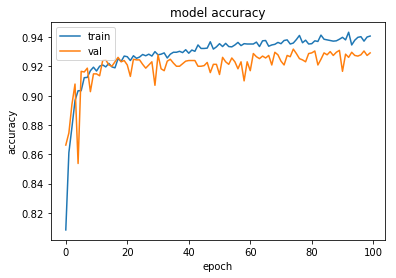

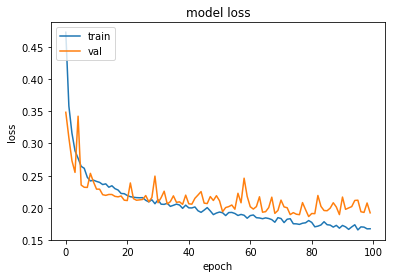

In [44]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
#每一个类别，进行识别率和F1-score验证
pred_y = model.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)

In [74]:
from sklearn.metrics import classification_report

print (classification_report(test_idx, pred_idx))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

          0       0.92      0.98      0.95      1365
          1       0.96      0.88      0.92       939

avg / total       0.94      0.94      0.94      2304



In [75]:
# from keras.models import Model
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer('dense1').output)

# intermediate_output = intermediate_layer_model.predict(test_X)

In [76]:
# from keras.models import load_model

model.save('single_layer_lstm.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

In [47]:
false_negative = (pred_idx==0) & (test_idx==1) #被认为是正常，但是实际上是异常
false_positive = (pred_idx==1) & (test_idx==0) #被认为是异常，但是实际上正常

In [55]:
a = test_X[false_negative]
a[2]

array([[ -4.45716865e-02,   2.48127244e-02,  -2.99533457e-03,
          3.77711095e-02,  -2.01363098e-02,  -8.21232796e-04,
         -2.22122427e-02,   1.65661424e-03,   4.33095582e-02,
         -1.35370716e-02,  -3.07257064e-02,  -7.83971697e-03,
         -3.05410028e-02,   1.24940872e-02,  -8.53099674e-03,
         -3.84224765e-02,   8.45156610e-04,  -1.63494349e-02,
         -1.83185823e-02,   2.41387151e-02,  -2.04124302e-03,
          8.04493576e-03,   3.02817486e-02,   4.75921147e-02,
          1.78544596e-03,  -4.99971211e-05,  -9.31336731e-03,
          3.86346690e-02,  -1.66543834e-02,   2.70787217e-02,
         -2.70835161e-02,  -4.63140979e-02],
       [  5.88121265e-03,   4.23409007e-02,   1.10298395e-02,
          6.15523010e-03,  -4.87679839e-02,  -3.83444056e-02,
         -9.24265385e-03,  -3.24575789e-02,  -2.41757166e-02,
          3.40597294e-02,   1.85414441e-02,   4.72379848e-03,
          5.77217340e-03,   3.65046374e-02,   3.73396538e-02,
         -9.65825468e-03,

In [102]:
def find_data_position(samples):
    indexes = list()
    for x in samples:
        a = (np.abs(iPAccessData.X-x).sum(axis=2).sum(axis=1)<0.00001)
        indexes.append(np.where(a==1)[0])
    return indexes

In [103]:
a = find_data_position(iPAccessData.X[2])
a

[array([], dtype=int64),
 array([], dtype=int64),
 array([3631, 3999, 5395], dtype=int64),
 array([ 1389,  1390,  1392,  1395,  1622,  1623,  1624,  1625,  1766,
         1812,  2490,  2542,  2714,  3028,  3032,  3036,  3037, 11172, 13212], dtype=int64),
 array([ 1389,  1390,  1392,  1395,  1622,  1623,  1624,  1625,  1766,
         1812,  2490,  2542,  2714,  3028,  3032,  3036,  3037, 11172, 13212], dtype=int64),
 array([3631, 3999, 5395], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([3631, 3999, 5395], dtype=int64),
 array([ 4983,  5211,  5737,  5741,  6683, 10934], dtype=int64),
 array([], dtype=int64),
 array([ 4983,  5211,  5737,  5741,  6683, 10934], dtype=int64),
 array([], dtype=int64),
 array([ 4983,  5211,  5737,  5741,  6683, 10934], dtype=int64),
 array([], dtype=int64),
 array([ 4983,  5211,  5737,  5741,  6683, 10934], dtype=int64),
 array([3631, 3999, 5395], dtype=int64),
 array([ 4983,  5211,  5737,  5741,  6683, 10934

In [99]:
test_X[[1,3,66]]

array([[[-0.04457169,  0.02481272, -0.00299533, ...,  0.02707872,
         -0.02708352, -0.0463141 ],
        [-0.04457169,  0.02481272, -0.00299533, ...,  0.02707872,
         -0.02708352, -0.0463141 ],
        [-0.04457169,  0.02481272, -0.00299533, ...,  0.02707872,
         -0.02708352, -0.0463141 ],
        ..., 
        [ 0.03835407,  0.00742059,  0.00048603, ...,  0.01160068,
          0.04037404,  0.00169437],
        [ 0.03835407,  0.00742059,  0.00048603, ...,  0.01160068,
          0.04037404,  0.00169437],
        [ 0.03835407,  0.00742059,  0.00048603, ...,  0.01160068,
          0.04037404,  0.00169437]],

       [[-0.04068493, -0.03271866,  0.01000916, ...,  0.00667908,
          0.00712705,  0.0426704 ],
        [-0.04068493, -0.03271866,  0.01000916, ...,  0.00667908,
          0.00712705,  0.0426704 ],
        [-0.04068493, -0.03271866,  0.01000916, ...,  0.00667908,
          0.00712705,  0.0426704 ],
        ..., 
        [-0.04068493, -0.03271866,  0.01000916, ...,

In [50]:
#读取之前的url_list数据，配合假阴性假阳性判断
class IPAccessInfo(object):
    def __init__(self, all_url_list, all_url_dict_list):
        self.all_url_list = all_url_list
        self.all_url_dict_list = all_url_dict_list
        
import pickle
fp = open('url_info.pkl','rb',True)
iPAccessInfo = pickle.load(fp)

In [94]:
false_negative_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_negative) if v==True]
false_negative_urls  #被认为是正常，但是实际上是异常的，看看对不对吧

NameError: name 'iPAccessInfo' is not defined

In [52]:
false_positive_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_positive) if v==True]
false_positive_urls  #被认为是异常，但是实际上是正常的，看看对不对吧

[['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'GET common/.../patientList.do',
  'GET /.../patientinfo.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'POST /.../reserve.do'],
 ['GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do'],
 ['GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'GET common/.../login.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do',
  'GET common/.../chooseExpert.do',
  'GET common/.../deptList.do',
  'POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do'],
 ['GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDe